# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: 
- Grupo México(AMXL.MX)
- Walmart de Mexico SAB de CV	(WALMEX.MX) 
- BIMBO (BIMBOA.MX)
- Banorte (GFBANORTEO.MX)

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Bajamos los ETF de yahoo
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

tickers = ['GOOGL', 'EFX', 'COST', 'WMT', 'PG',
     'DIS', 'IBM', 'AMZN', 'TGT', 'JPM', 'INTC',
    'MSFT', 'BLK', 'NFLX']
start_date = '2015-01-01'


St = yf.download(tickers, start=start_date)['Close']
St.head()
rt = St.pct_change().dropna()


[*********************100%%**********************]  14 of 14 completed


In [2]:
St 

,AMZN,BLK,COST,DIS,EFX,GOOGL,IBM,INTC,JPM,MSFT,NFLX,PG,TGT,WMT
Date,,,,,,,,,,,,,,
2015-01-02,15.426000,356.730011,141.610001,93.750000,81.320000,26.477501,154.933075,36.360001,62.490002,46.759998,49.848572,90.440002,75.330002,85.900002
2015-01-05,15.109500,347.500000,140.000000,92.379997,80.639999,25.973000,152.495224,35.950001,60.549999,46.330002,47.311428,90.010002,73.980003,85.650002
2015-01-06,14.764500,342.100006,141.850006,91.889999,80.000000,25.332001,149.206497,35.279999,58.980000,45.650002,46.501431,89.599998,73.970001,86.309998
2015-01-07,14.921000,349.339996,144.320007,92.830002,81.349998,25.257500,148.231354,36.020000,59.070000,46.230000,46.742859,90.070000,76.769997,88.599998
2015-01-08,15.023000,353.420013,145.559998,93.790001,83.089996,25.345501,151.453156,36.689999,60.389999,47.590000,47.779999,91.099998,77.129997,90.470001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,126.559998,614.729980,552.289978,83.099998,179.039993,136.500000,136.380005,33.849998,141.000000,329.320007,406.839996,148.149994,107.419998,161.009995
2023-10-24,128.559998,612.390015,551.840027,82.559998,169.699997,138.809998,137.789993,34.590000,141.169998,330.529999,413.730011,149.899994,108.680000,163.250000
2023-10-25,121.389999,608.679993,549.989990,80.589996,164.169998,125.610001,137.080002,32.830002,140.399994,340.670013,411.250000,150.600006,110.360001,162.759995


1.2. A partir de los precios, obtener los rendimientos mensuales:

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [3]:
# Matriz de covarianza
rt.corr()
sigma = rt.cov() 

In [4]:
# Tasa libre de riesgo
rf = 0.04

In [5]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
# ¿cuantos portafolios?
# ¿cuantos actvos?
n_port = 10000
n_act = len(rt.keys())

In [6]:
# Generar una matriz de pesos de n_portafolios x n_activos,
# tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet((1,) * n_act, size = n_port)

In [7]:
# Calcula el valor esperado
valores_esperados_markowitz = W.dot(rt.mean()) * 252 

$$E[P] = W * E[stocks_i] $$

In [8]:
# Rendimientos y volatilidad de cada portafolios
volatility_markowitz = []
for i in W: 
    variance = i.dot(sigma).dot(i.T)
    volatility = np.sqrt(variance) * np.sqrt(252)
    volatility_markowitz.append(volatility)
    

$$Var(P) = W^T \Sigma W $$
$$\sigma_p = \sqrt{Var(P)}$$

In [9]:
df = pd.DataFrame({
    'expected_value' : valores_esperados_markowitz, 
    'volatility' : volatility_markowitz
    
    })

df.head()

,expected_value,volatility
0,0.191760,0.205175
1,0.111524,0.206409
2,0.134386,0.193848
3,0.147167,0.182417
4,0.146882,0.207289


In [10]:
# ¿Cuanto en cada activo?

# 'GOOGL', 'EFX', 'COST', 'WMT', 'PG',
#      'DIS', 'IBM', 'AMZN', 'TGT', 'JPM', 'INTC',
#      'MSFT', 'BLK', 'NFLX'

df['W_GOOGL'] = [i[0] for i in W]
df['W_ETX'] = [i[1] for i in W]
df['W_COST'] = [i[2] for i in W]
df['W_WMT'] = [i[3] for i in W]
df['W_PG'] = [i[0] for i in W]
df['W_DIS'] = [i[1] for i in W]
df['W_IMB'] = [i[2] for i in W]
df['W_AMZN'] = [i[3] for i in W]
df['W_TGT'] = [i[0] for i in W]
df['W_JPM'] = [i[1] for i in W]
df['W_INTC'] = [i[2] for i in W]
df['W_MSFT'] = [i[3] for i in W]
df['W_BLK'] = [i[0] for i in W]
df['W_NFLX'] = [i[1] for i in W]

In [11]:
df

,expected_value,volatility,W_GOOGL,W_ETX,W_COST,W_WMT,W_PG,W_DIS,W_IMB,W_AMZN,W_TGT,W_JPM,W_INTC,W_MSFT,W_BLK,W_NFLX
0,0.191760,0.205175,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663
1,0.111524,0.206409,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177
2,0.134386,0.193848,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495
3,0.147167,0.182417,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778
4,0.146882,0.207289,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.173548,0.210187,0.081104,0.104120,0.002546,0.041370,0.081104,0.104120,0.002546,0.041370,0.081104,0.104120,0.002546,0.041370,0.081104,0.104120
9996,0.150446,0.201990,0.052901,0.203382,0.137519,0.017731,0.052901,0.203382,0.137519,0.017731,0.052901,0.203382,0.137519,0.017731,0.052901,0.203382
9997,0.149040,0.188316,0.093337,0.128429,0.011714,0.014295,0.093337,0.128429,0.011714,0.014295,0.093337,0.128429,0.011714,0.014295,0.093337,0.128429
9998,0.150691,0.207911,0.162334,0.107667,0.066199,0.001714,0.162334,0.107667,0.066199,0.001714,0.162334,0.107667,0.066199,0.001714,0.162334,0.107667


In [12]:
df['sharpe'] = ( df.expected_value - rf) / df.volatility
df.head()

,expected_value,volatility,W_GOOGL,W_ETX,W_COST,W_WMT,W_PG,W_DIS,W_IMB,W_AMZN,W_TGT,W_JPM,W_INTC,W_MSFT,W_BLK,W_NFLX,sharpe
0,0.191760,0.205175,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663,0.182439,0.022692,0.240001,0.023663,0.739659
1,0.111524,0.206409,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177,0.115275,0.033266,0.062262,0.016177,0.346515
2,0.134386,0.193848,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495,0.056206,0.009043,0.069283,0.106495,0.486907
3,0.147167,0.182417,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778,0.083180,0.004731,0.061821,0.045778,0.587483
4,0.146882,0.207289,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718,0.074673,0.169896,0.033092,0.105718,0.515617


$$Sharpe = \frac{E_s - rf}{\sigma_s}$$

In [13]:
# Radio de Sharpe
df_max_sharpe = df[df.sharpe == df.sharpe.max() ]
df_max_sharpe

,expected_value,volatility,W_GOOGL,W_ETX,W_COST,W_WMT,W_PG,W_DIS,W_IMB,W_AMZN,W_TGT,W_JPM,W_INTC,W_MSFT,W_BLK,W_NFLX,sharpe
6530,0.226149,0.231962,0.198354,0.015832,0.057275,0.003094,0.198354,0.015832,0.057275,0.003094,0.198354,0.015832,0.057275,0.003094,0.198354,0.015832,0.802498


In [14]:
sharpe_maximo = df_max_sharpe.sharpe.values[0]
sharpe_maximo

0.8024980804117006

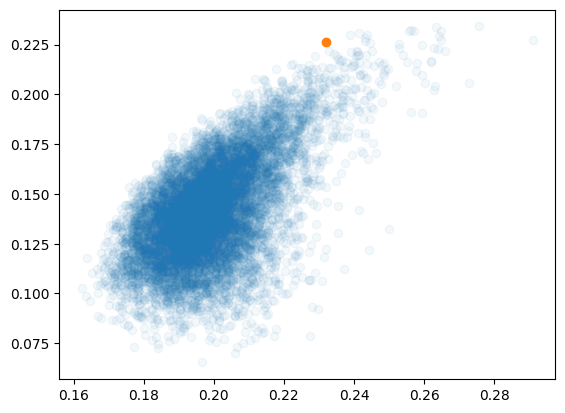

In [15]:
# Data frame de resultados
plt.scatter(df.volatility, df.expected_value, alpha = 0.05)
plt.scatter(df_max_sharpe.volatility, df_max_sharpe.expected_value)

In [16]:
sharpe_maximo = df_max_sharpe.sharpe.values[0]
sharpe_maximo

0.8024980804117006

In [17]:
# Obten la LAC
volatility_portafolios = np.linspace(0, 0.5, 100)
lac = rf + sharpe_maximo * volatility_portafolios

Text(0.5, 1.0, 'Linea de asignacion de cpaitales, a mayor dinero en acciones, mas rendimiento')

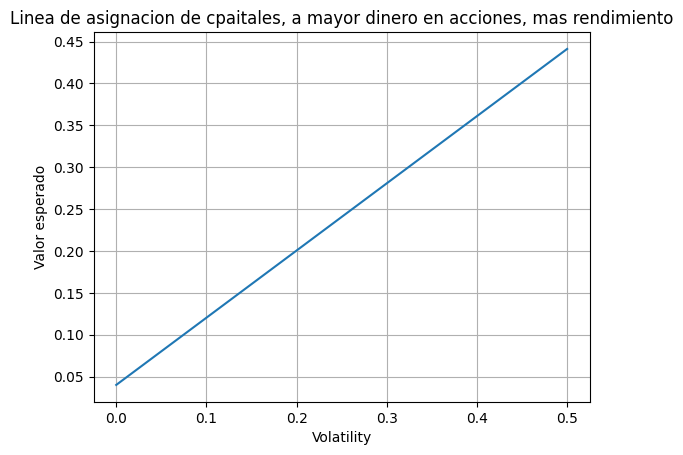

In [18]:
# Grafica LAC
plt.plot(volatility_portafolios, lac) 
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Valor esperado') 
plt.title('Linea de asignacion de cpaitales, a mayor dinero en acciones, mas rendimiento') 

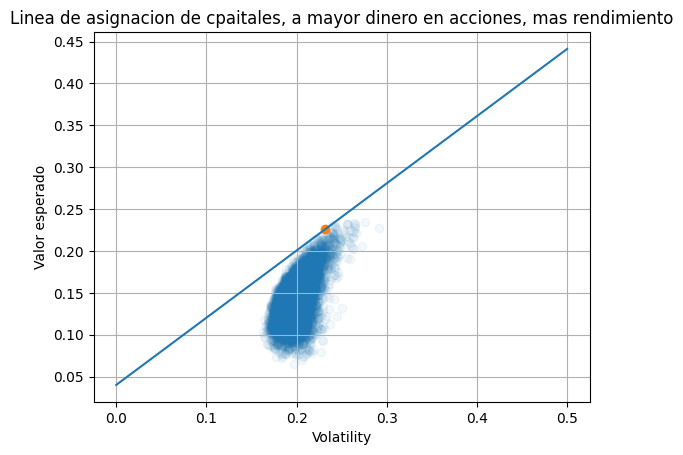

In [19]:
# Gráfica Markowitz + LAC
plt.plot(volatility_portafolios, lac) 
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Valor esperado') 
plt.title('Linea de asignacion de cpaitales, a mayor dinero en acciones, mas rendimiento') 
plt.scatter(df.volatility, df.expected_value, alpha = 0.05)
plt.scatter(df_max_sharpe.volatility, df_max_sharpe.expected_value)

$$w_{stocks} = \frac{e_{emv} - rf}{\sigma_{emv}^2 * \alpha} $$

In [20]:
e_emv = df_max_sharpe.expected_value.values[0]
s_emv = df_max_sharpe.volatility.values[0]

In [21]:
# ¿Cuanto invertir en cada una?
aversion = np.linspace(0, 10, 10) 
cuanto_va_en_cada_una = pd.DataFrame({
    'aversion' : aversion, 
    'cuanto_acciones' : (e_emv - rf) / (s_emv ** 2 * aversion) 
    
    })

cuanto_va_en_cada_una['cuanto_cetes'] = 1 - cuanto_va_en_cada_una['cuanto_acciones']
cuanto_va_en_cada_una

/tmp/ipykernel_51384/568402111.py:5: RuntimeWarning: divide by zero encountered in divide
  'cuanto_acciones' : (e_emv - rf) / (s_emv ** 2 * aversion)


,aversion,cuanto_acciones,cuanto_cetes
0,0.000000,inf,-inf
1,1.111111,3.113647,-2.113647
2,2.222222,1.556823,-0.556823
3,3.333333,1.037882,-0.037882
4,4.444444,0.778412,0.221588
5,5.555556,0.622729,0.377271
6,6.666667,0.518941,0.481059
7,7.777778,0.444807,0.555193
8,8.888889,0.389206,0.610794
9,10.000000,0.345961,0.654039


# Observaciones 

- Como tenemos valores negativos en coeficientes de riesgo < 4, podemos decir que en este caso tenemos un aversion al riesgo reducida, no se podra optener una ganancia optima. Por lo que para obtener el mayor rendimiento posible tenemos que tener un indice de aversion al riesgo de por lo menos 4.
- Tambien podemos ver que entre mas aversion al riesgo tengamos mayor aversion al riesgo se presente, se tendra que invertir principalmente en cetes, lo cual 